This notebook reads data that we've downloaded from the LA City website and puts it into a big file

In [1]:
import os
import ast
import uuid
from itertools import product
from collections import Counter

import numpy as np
import pandas as pd

import networkx as nx

import geopandas as gpd
from geopy.distance import great_circle
import pyproj
import shapely as shapely
from geopy.distance import great_circle

from tqdm import tqdm

from scipy.spatial import KDTree

import matplotlib.pyplot as plt
%matplotlib nbagg

DATA_DIR = '~/GitHub/la_mayors_office/data'

In [4]:
def make_APN(df):
    """ This function will add an APN column to a dataset
    made by concatenting the partial APNs
    """

    apn_cols = ['Assessor Book', 'Assessor Page', 'Assessor Parcel']
    series_apn = df[apn_cols].astype(str).apply(lambda x: ''.join(x), axis=1)
    
    series_apn[series_apn.str.contains('nan')] = ''
    series_apn[series_apn.str.contains('\*')] = ''
    return series_apn

# Process certificate of occupancy

Read it in, drop columns we don't care about and output a 'trimmed' version

Notes:
    PCIS = "Plan Check and Inspection System"
    "# of Residential Dwelling Units" may for additions/remodeling may just measure the number of units affected

In [12]:
fname_input = "Building_and_Safety_Certificate_of_Occupancy.csv"
fname_output = "Trimmed_Occupancy.csv"

location_columns = [
    "APN",
    "Latitude/Longitude",
    "Census Tract"
]

address_columns = [
    "Address Start",
    "Address Fraction Start",
    "Address End",
    "Address Fraction End",
    "Street Direction",
    "Street Name",
    "Street Suffix",
    "Suffix Direction",
    "Unit Range Start",
    "Unit Range End",
    "Zip Code"
]

permit_columns = [
    "Status",
    "Status Date",
    "# of Residential Dwelling Units",
    "PCIS Permit #",
    "Permit Type",
    "Permit Sub-Type",
    "Applicant First Name",
    "Applicant Last Name",
    "Applicant Business Name",
]

extra_columns = [
    "Valuation",
    "Work Description",
    "Contractor's Business Name",
    "# of Stories"
]

df_CofO = pd.read_csv(os.path.join(DATA_DIR, fname_input), dtype=str)
df_CofO['Status Date'] = pd.to_datetime(df_CofO['Permit Issue Date'])

# Make APN
df_CofO["APN"] = make_APN(df_CofO)

df_CofO_trimmed = df_CofO[location_columns + address_columns + permit_columns + extra_columns]

df_CofO_trimmed.to_csv(
    os.path.join(DATA_DIR, fname_output),
    index=False
)

# Process demolition permits

Read it in, drop columns we don't care about, drop rows that are not demolition permits, and output a 'trimmed' version

Notes:


In [13]:
location_columns = [
    "APN",
    "Latitude/Longitude",
    "Census Tract"
]

address_columns = [
    "Address Start",
    "Address Fraction Start",
    "Address End",
    "Address Fraction End",
    "Street Direction",
    "Street Name",
    "Street Suffix",
    "Suffix Direction",
    "Unit Range Start",
    "Unit Range End",
    "Zip Code"
]

permit_columns = [
    "Status",
    "Status Date",
    "PCIS Permit #",
    "Reference # (Old Permit #)",
    "Permit Type",
    "Permit Sub-Type",
    "Applicant First Name",
    "Applicant Last Name",
    "Applicant Business Name",
]

extra_columns = [
    "Valuation",
    "Work Description",
    "Contractor's Business Name",
    "Council District",
]


fname_input = "Building_and_Safety_Permit_Information.csv"
fname_output = "Trimmed_Demolition.csv"

df_demolition = pd.read_csv(os.path.join(DATA_DIR, fname_input), dtype=str)
df_demolition['Status Date'] = pd.to_datetime(df_demolition['Status Date'])

# Make APN
df_demolition["APN"] = make_APN(df_demolition)

rows_is_demolition = df_demolition['Permit Type'].isin(['Bldg-Demolition', 'NonBldg-Demolition'])

df_demolition = df_demolition.loc[
    rows_is_demolition,
    location_columns + address_columns + permit_columns + extra_columns
]

df_demolition.to_csv(
    os.path.join(DATA_DIR, fname_output),
    index=False
)

# Process building permits

Read it in, drop columns we don't care about, drop rows that are demolition permits, and output a 'trimmed' version

Notes:


In [14]:
fname_input = "Building_and_Safety_Permit_Information.csv"
fname_output = "Trimmed_Building.csv"

df_building = pd.read_csv(os.path.join(DATA_DIR, fname_input), dtype=str)
df_building['Status Date'] = pd.to_datetime(df_building['Status Date'])

# Make APN
df_building["APN"] = make_APN(df_building)

rows_is_demolition = df_building['Permit Type'].isin(['Bldg-Demolition', 'NonBldg-Demolition'])

df_building = df_building.loc[
    ~rows_is_demolition,
    location_columns + address_columns + permit_columns + extra_columns
]

df_building.to_csv(
    os.path.join(DATA_DIR, fname_output),
    index=False
)

# Concatenate all the trimmed docs into a single dataframe

Read all the trimmed dataframes and the geocoded information about Ellis withdrawals into a single mega-file

In [15]:
fname_list = [
    ("Ellis Withdrawal", "Ellis_withdrawals_geocoded.csv"),
    ("Demolition Permit", "Trimmed_Demolition.csv"),
    ("Building Permit", "Trimmed_Building.csv"),
    ("Occupancy Inspection", "Trimmed_Occupancy.csv")
]

fname_output = 'la_housing_dataset.csv'

df_full = []
for f in fname_list:
    df = pd.read_csv(os.path.join(DATA_DIR, f[1]))
    df["General Category"] = f[0]
    df_full.append(df)
df_full = pd.concat(df_full, axis=0).fillna(value='')
df_full.APN = df_full.APN.astype(str)
df_full['Status Date'] = pd.to_datetime(df_full['Status Date'])

/Users/mcmenamin/.virtualenvs/py2env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Study variation in geocoding within a single APN

Becuase APNs change over time, we need to come up with a more permenant identifier for properties in the dataset. That identifier will use geocoding to link APNs together.

But first, we need to understand what the geocoding looks like. The first step will be to look at how tightly clustered the geolocations across records within a single APN.

In [16]:
def string_to_point(x):
    try:
        coord = ast.literal_eval(x)
    except SyntaxError:
        return None
    return shapely.geometry.point.Point(coord)
    
gdf_full = gpd.GeoDataFrame(df_full.copy())
gdf_full['geometry'] = gdf_full['Latitude/Longitude'].apply(string_to_point)
gdf_full.geometry.crs = {'proj': 'latlong'}
gdf_full = gdf_full.set_geometry('geometry')

# Figure out how much geocoding variation existing within a known APN

def get_maximum_distance(latlong_series):
    if latlong_series.shape[0] > 1:
        corners = shapely.geometry.MultiPoint(latlong_series.values).bounds
        max_error = great_circle(corners[:2], corners[2:]).feet
        return max_error
    return 0

permit_apns = set(gdf_full.loc[df_full['General Category'] != 'Ellis Withdrawal', 'APN'])
ellis_apns = set(gdf_full.loc[df_full['General Category'] == 'Ellis Withdrawal', 'APN'])

df_geoerror = []
for apn in list(permit_apns & ellis_apns):
    data = gdf_full.loc[gdf_full.APN == apn, 'geometry']
    data = data[data.apply(lambda x: type(x)==shapely.geometry.point.Point)]
    df_geoerror.append({
        'APN': apn,
        'num_points': data.shape[0],
        'feet_error': get_maximum_distance(data)  
    })
df_geoerror = pd.DataFrame(df_geoerror)

In [17]:
df_geoerror.loc[df_geoerror.num_points > 1, ['feet_error']].describe()

,feet_error
count,823.000000
mean,183.148385
std,1709.677791
min,0.000000
25%,64.003861
50%,104.810679
75%,157.452036
max,49061.766501


<IPython.core.display.Javascript object>


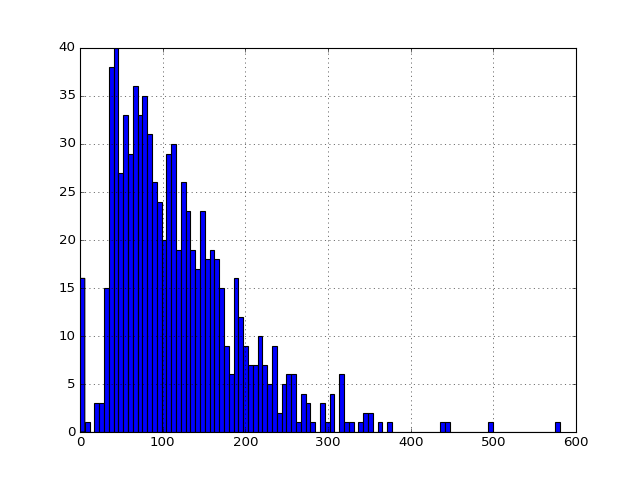

In [18]:
plt.figure()
df_geoerror.loc[(df_geoerror.num_points > 1) & (df_geoerror.feet_error < 800), 'feet_error'].hist(bins=100)

### Study variation in geocoding within a single APN

The plots above indicate that APNs rarely have geolocated coordinates more than 300 feet apart. However, to figure out what our distance threshold should be, we also need to look at how close together known *different* APNs can end up. 

We'll do that next by measuring how close the nearests neighbors generally are for a bunch of other APNs

In [20]:
# Make the multipoint shape for every APN (except ellis ones)
_df = gdf_full.loc[gdf_full.APN.isin(permit_apns - ellis_apns - set([''])), ['APN', 'geometry']]
_df = _df[_df.geometry.apply(lambda x: type(x)==shapely.geometry.point.Point)]

shape_dict = {}
for apn, points in _df.groupby('APN'):
    shape_dict[apn] = points.geometry.values

def get_min_dist(list_a, list_b):
    closest_pair = None
    best_dist = float('Inf')
    for pair in product(list_a, list_b):
        cur_dist = pair[0].distance(pair[1])
        if cur_dist < best_dist:
            best_dist = cur_dist
            closest_pair = pair

    min_dist = great_circle(
        (closest_pair[0].x, closest_pair[0].y),
        (closest_pair[1].x, closest_pair[1].y)).feet
    return min_dist

df_geo_neighbor = []
for apn1, apn2 in tqdm(product(shape_dict.keys(), repeat=2)):
    if apn1 > apn2:
        df_geo_neighbor.append({
            'APN1': apn1,
            'APN2': apn2,
            'num_points1': len(shape_dict[apn1]),
            'num_points2': len(shape_dict[apn2]),
            'feet_apart': get_min_dist(shape_dict[apn1], shape_dict[apn2])  
        })
    if len(df_geo_neighbor) >= 1000000:
        break

2204240it [02:30, 14689.90it/s]

In [21]:
df_geo_neighbor = pd.DataFrame(df_geo_neighbor)
df_geo_neighbor2 = df_geo_neighbor.copy().rename(columns={'APN1':'APN2', 'APN2':'APN1',
                                                          'num_points1':'num_points2',
                                                          'num_points2':'num_points1'})
df_geo_neighbor = pd.concat([df_geo_neighbor, df_geo_neighbor2], axis=0)

df_nn = df_geo_neighbor.groupby('APN1')['feet_apart'].min()

In [22]:
df_nn.describe()

count    258943.000000
mean      31805.131981
std       22578.840300
min           0.000000
25%       16578.073867
50%       27495.952167
75%       38726.177752
max      132850.897259
Name: feet_apart, dtype: float64

In [24]:
(df_nn < 100).sum()

16

<IPython.core.display.Javascript object>


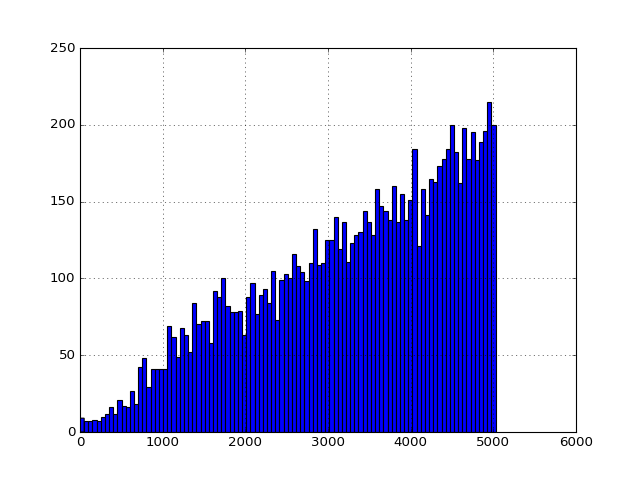

In [25]:
plt.figure()
df_nn[df_nn < 5028].hist(bins=100)

<IPython.core.display.Javascript object>


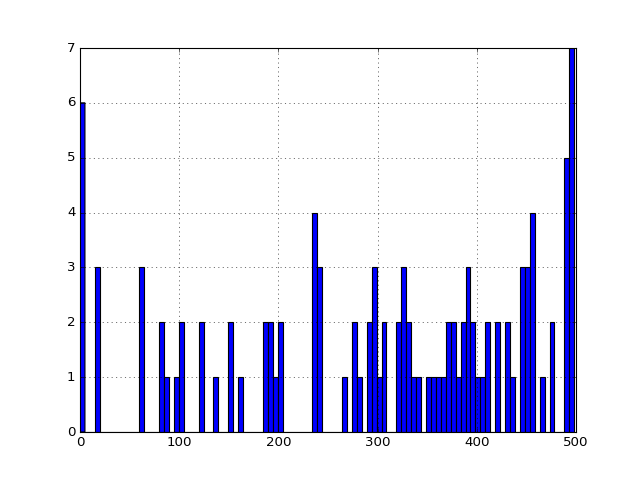

In [26]:
plt.figure()
df_nn[df_nn < 500].hist(bins=100)

Here we see that some APNs geolocate to as little as 100 feet of each other, so we'll play it safe and set our threshold pretty far below that -- 25 feet.

The reason that the number is so far below 100 is that my first pass at this used 100, and it ended up merging WAAY too many houses together in dense regions (if there were a bunch of neighbors ~100 feet apart, it'd merge ALL of them into a mega-APN).

In [27]:
ECEF = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
LLA = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

def ll_to_ecef(centroid):
    xyz = pyproj.transform(LLA, ECEF,
                           centroid.coords[0][1],
                           centroid.coords[0][0],
                           0,
                           radians=False)
    xyz = [i * (3.3) for i in xyz]
    return xyz

# Get centroid of each APN
_df = gdf_full.loc[gdf_full.APN != '', ['APN', 'geometry']]
_df = _df[_df.geometry.apply(lambda x: type(x)==shapely.geometry.point.Point)]

apn_centroid = {}
for apn, points in _df.groupby('APN'):
    apn_centroid[apn] = shapely.geometry.MultiPoint(points.geometry.values).centroid
    
# Get centroids in ECEF coords
apn_ecef = {a: ll_to_ecef(apn_centroid[a]) for a in apn_centroid}

# Put ECEF coords into a KDTree for easy NN lookup
apn_list = [a for a in apn_ecef]
ecef_list = np.vstack([apn_ecef[a] for a in apn_list])
ecef_tree = KDTree(ecef_list)

In [ ]:
# Make a graph that links APNs within 25 feet of one another. 

THRESH_FEET = 25
points_to_merge = ecef_tree.query_ball_tree(ecef_tree, THRESH_FEET)

graph = nx.Graph()
for points in points_to_merge:
    for p in points:
        graph.add_node(p)
    
    for edge in product(points, repeat=2):
        graph.add_edge(*edge)

# Extract the connected components of that graph to find connected groups of APNs/
# Each cluster gets a unique 'property_id' code
apn_to_prop_id = {}
for comp in nx.algorithms.components.connected_components(graph):
    new_id = str(uuid.uuid1(clock_seq=len(apn_to_prop_id)))        
    for i in list(comp):
        apn_to_prop_id[apn_list[i]] = new_id

# add in the APNs that didn't geo-code as their own clusters
for a in gdf_full.APN.unique():
    if a not in apn_to_prop_id:
        new_id = str(uuid.uuid1(clock_seq=len(apn_to_prop_id)))        
        apn_to_prop_id[a] = new_id

apn_to_prop_id[''] = ''

# check out the distro of how many to merge together
prop_id_to_apn = {}
for a in apn_to_prop_id:
    prop_id = apn_to_prop_id[a]
    if prop_id in prop_id_to_apn:
        prop_id_to_apn[prop_id].append(a)
    else:
        prop_id_to_apn[prop_id] = [a]
        
print(Counter([len(i) for i in prop_id_to_apn.values()]))

In [43]:
df_full['property_id'] = df_full.APN.apply(lambda x: apn_to_prop_id[x])
df_full = df_full.sort_values(["property_id", "APN", "Status Date"]).reset_index(drop=True)

# Re-ordering columns to be easier to read
new_order = ["property_id"] + location_columns + address_columns + ["General Category"] + permit_columns
new_order += [c for c in df_full if c not in new_order]
df_full = df_full[new_order]

df_full.to_csv(
    os.path.join(DATA_DIR, fname_output),
    index=False
)

In [46]:
# Check out date ranges for each permit type
pd.concat([
    df_full.groupby('General Category')['Status Date'].min(),
    df_full.groupby('General Category')['Status Date'].max()
],axis=1)

,Status Date,Status Date
General Category,,
Building Permit,2013-01-02,2020-06-24
Demolition Permit,2013-01-04,2017-10-14
Ellis Withdrawal,2007-07-18,2017-07-31
Occupancy Inspection,2013-01-02,2017-10-12


In [47]:
%system
aws s3 cp ~/GitHub/la_mayors_office/data/la_housing_dataset.csv s3://datadive-democraticfreedom-nyc/LA\ Mayor\'s\ Office\ \-\ Housing/Raw\ Data/
    
    

SyntaxError: invalid syntax (<ipython-input-47-fbdbaf08f86e>, line 2)

In [ ]:
df_full = df_full.drop('geometry', 1)